<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Synthetic-data" data-toc-modified-id="Synthetic-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Synthetic data</a></span><ul class="toc-item"><li><span><a href="#Run-simulations" data-toc-modified-id="Run-simulations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Run simulations</a></span></li><li><span><a href="#Compare-the-algorithms" data-toc-modified-id="Compare-the-algorithms-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Compare the algorithms</a></span><ul class="toc-item"><li><span><a href="#quantiles" data-toc-modified-id="quantiles-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>quantiles</a></span></li><li><span><a href="#UCB,-MeanAA,-Adaptive" data-toc-modified-id="UCB,-MeanAA,-Adaptive-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>UCB, MeanAA, Adaptive</a></span></li><li><span><a href="#MeanAA-to-Adaptive" data-toc-modified-id="MeanAA-to-Adaptive-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>MeanAA to Adaptive</a></span></li><li><span><a href="#Agg-algorithms-with/without-mean" data-toc-modified-id="Agg-algorithms-with/without-mean-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Agg algorithms with/without mean</a></span></li></ul></li></ul></li><li><span><a href="#Avocado-data" data-toc-modified-id="Avocado-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Avocado data</a></span><ul class="toc-item"><li><span><a href="#Run-simulations" data-toc-modified-id="Run-simulations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Run simulations</a></span></li><li><span><a href="#Compare-the-algorithms" data-toc-modified-id="Compare-the-algorithms-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Compare the algorithms</a></span><ul class="toc-item"><li><span><a href="#quantiles" data-toc-modified-id="quantiles-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>quantiles</a></span></li><li><span><a href="#UCB,-MeanAA,-Adaptive" data-toc-modified-id="UCB,-MeanAA,-Adaptive-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>UCB, MeanAA, Adaptive</a></span></li><li><span><a href="#MeanAA-to-Adaptive" data-toc-modified-id="MeanAA-to-Adaptive-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>MeanAA to Adaptive</a></span></li><li><span><a href="#Agg-algorithms-with/without-mean" data-toc-modified-id="Agg-algorithms-with/without-mean-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Agg algorithms with/without mean</a></span></li></ul></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
import itertools

import scipy.stats as ss
from joblib import Parallel, delayed

from bandits.pricing.bandits import PricingBernoulliBanditEnv
from bandits.pricing.agents import UCB1OAgent, SLRAgent, AggregatingAgent

from bandits.bandits import BernoulliBanditEnv
from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

from copy import deepcopy
from bandits.online_models import (
    ConstantModel, SimpleLinearRegressor,
    OnlinePredictionEnv, TargetEncodingModel
)
from bandits.aggregating_algorithms import (
    SimpleMeanAggregatingAlgorithm, Hedge,
    MultiplicativeWeights, AdaHedge
)

## Synthetic data

In [4]:
p_min = .1
p_max = 1
K = 10

dist_mean = .5
dist_std = 0.5
dist = ss.norm(loc=dist_mean, scale=dist_std)

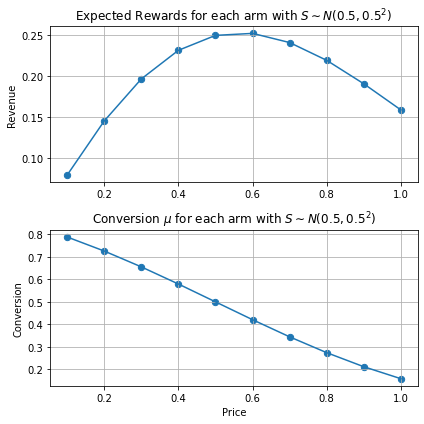

In [5]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
plt.grid()
plt.ylabel('Revenue')
plt.title(r'Expected Rewards for each arm with $S \sim N(0.5, 0.5^2)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title(r'Conversion $\mu$ for each arm with $S \sim N(0.5, 0.5^2)$')
fig.tight_layout();

### Run simulations

In [6]:
np.random.seed(2)
N_SIMULATIONS = 50
T = 5000

eps = 1e-2  # probability of exploration
alpha = 0.25**2/2

In [7]:
p_min = 0.1
p_max = 1
K = 10

dist_mean = .5
dist_std = 0.5
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [8]:
def simulate_agent(T, K, dist, p_min, p_max, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    env = PricingBernoulliBanditEnv(num_arms=K, dist=dist, p_min=p_min, p_max=p_max)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    for _ in range(T):
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        reward_history.append(reward)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(env.max_reward - reward_history)
    return rng_seed, name, regret

In [9]:
lr_models = [
    SimpleLinearRegressor(0, 0),
    SimpleLinearRegressor(0, 0, x_transform=np.log),
    SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1),
    SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x),
]
MeanAA_agg_alg = SimpleMeanAggregatingAlgorithm(lr_models)
hedge_agg_alg = Hedge(lr_models)
adahedge_agg_alg = AdaHedge(lr_models)
multw_agg_alg = MultiplicativeWeights(lr_models, eta=0.5)

with_mean_models = lr_models + [TargetEncodingModel()]
h_mean_agg = Hedge(with_mean_models)
ah_mean_agg = AdaHedge(with_mean_models)
mw_mean_agg = MultiplicativeWeights(with_mean_models, eta=0.5)

agent_funcs = [
    ("UCB1", lambda env: UCB1Agent(alpha=1.25*alpha, num_arms=env.action_space.n)),
    ("MeanAA", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=MeanAA_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Hedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=hedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("AdaHedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=adahedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Multiplicative Weights", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=multw_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Hedge with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=h_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
    ("AdaHedge with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=ah_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Multiplicative Weights with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=mw_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [10]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(T, K, dist, p_min, p_max, agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/400 [00:00<?, ?it/s]

In [11]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])
results_df['final_regret'] = results_df['regret'].apply(lambda x: x[-1])

In [12]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

In [13]:
agents = ['UCB1', 'MeanAA', 'Hedge', 'AdaHedge', 'Multiplicative Weights']

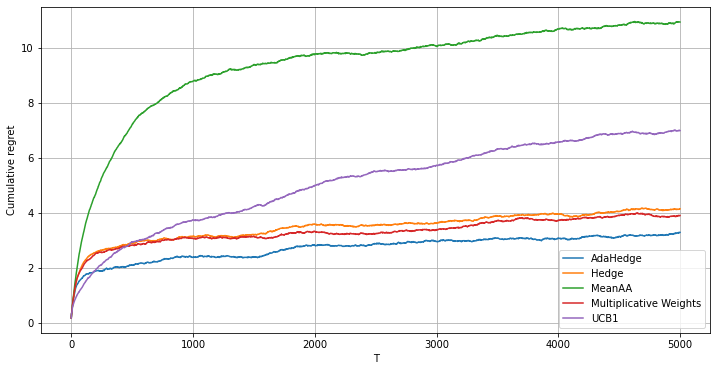

In [14]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    if name not in agents:
        continue
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

### Compare the algorithms

#### quantiles

In [15]:
# quantiles
q1 = 0.1
q2 = 1 - q1

In [16]:
agents = [
    'UCB1', 'MeanAA',
    'Hedge', 'AdaHedge', 'Multiplicative Weights',
    'Hedge with mean', 'AdaHedge with mean', 'Multiplicative Weights with mean']

In [17]:
q1_col = f'quantile {100*q1}%'
q2_col = f'quantile {100*q2}%'

In [18]:
quantile_df = pd.DataFrame()
for name in agents:
    if name not in agent_to_regret.keys():
        continue
    regret = agent_to_regret[name]
    quantiles = np.quantile(regret, [q1, q2], axis=0).T
    mean = np.mean(regret, axis=0)
    qqm = np.hstack([np.quantile(regret, [q1, q2], axis=0).T, np.mean(regret, axis=0).reshape(-1, 1)])
    qqm = pd.DataFrame(qqm, columns=[q1_col, q2_col, 'mean'])
    qqm['agent'] = name
    qqm['T'] = qqm.index
    quantile_df = pd.concat([quantile_df, qqm])

In [19]:
quantile_df[quantile_df['T'] == quantile_df['T'].max()]

,quantile 10.0%,quantile 90.0%,mean,agent,T
4999,4.959672,9.669272,6.991972,UCB1,4999
4999,7.972572,13.913372,10.939912,MeanAA,4999
4999,1.802672,7.476772,4.144812,Hedge,4999
4999,1.441672,5.521672,3.285412,AdaHedge,4999
4999,1.520972,6.742672,3.901892,Multiplicative Weights,4999
4999,1.275772,6.109372,3.629992,Hedge with mean,4999
4999,0.480272,5.601572,2.866572,AdaHedge with mean,4999
4999,0.150872,6.840272,3.335852,Multiplicative Weights with mean,4999


#### UCB, MeanAA, Adaptive

In [20]:
agents = ['UCB1', 'MeanAA', 'AdaHedge']
colors = ['mediumpurple', 'green', 'red']  # to make them match the previous plot

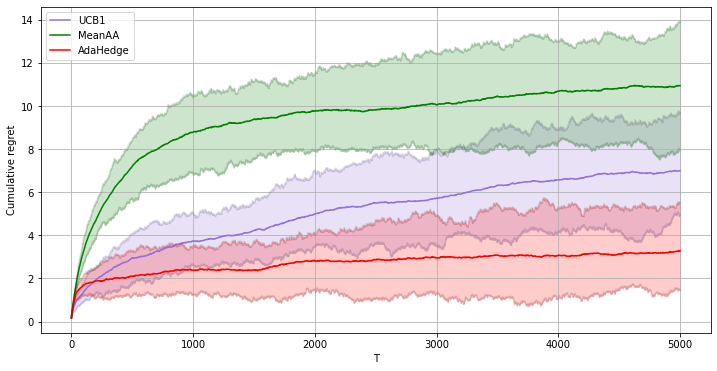

In [21]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for agent,c in zip(agents, colors):
    agent_df = quantile_df[quantile_df['agent'] == agent]
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df, color=c)
    plt.fill_between(x=ts, y1=agent_df[q1_col], y2=agent_df[q2_col], alpha=0.2, color=c)
    sns.lineplot(x='T', y=q1_col, data=agent_df, color='black', alpha=0.1)
    sns.lineplot(x='T', y=q2_col, data=agent_df, color='black', alpha=0.1)

plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [22]:
agents = ['MeanAA', 'Hedge', 'AdaHedge', 'Multiplicative Weights']

In [23]:
agent_to_outperforms = []
for agent in agents:
    tmp = results_df[results_df['algorithm'] == agent].merge(
        results_df[results_df['algorithm'] == 'UCB1'], on='simulation')
    assert len(tmp) > 0, agent
    # the lower the regret - the better
    n_outperformed = np.sum(tmp['final_regret_x'] < tmp['final_regret_y'])
    agent_to_outperforms.append((agent, n_outperformed))

In [24]:
outperforms_df = pd.DataFrame(agent_to_outperforms, columns=['algorithm', 'outperformed'])
outperforms_df['outperformed proportion'] = outperforms_df['outperformed'] / N_SIMULATIONS
outperforms_df['z-statistic'] = (outperforms_df['outperformed proportion']-0.5)/\
    np.sqrt(outperforms_df['outperformed proportion']*(1-outperforms_df['outperformed proportion'])/N_SIMULATIONS)
outperforms_df['Prob'] = 1-ss.norm.cdf(np.abs(outperforms_df['z-statistic']))
outperforms_df['Prob'] = outperforms_df['Prob'].round(4)

In [25]:
outperforms_df

,algorithm,outperformed,outperformed proportion,z-statistic,Prob
0,MeanAA,4,0.08,-10.947007,0.0
1,Hedge,41,0.82,5.889681,0.0
2,AdaHedge,47,0.94,13.100809,0.0
3,Multiplicative Weights,42,0.84,6.557892,0.0


#### MeanAA to Adaptive

In [26]:
agents = ['MeanAA', 'Hedge', 'AdaHedge', 'Multiplicative Weights']

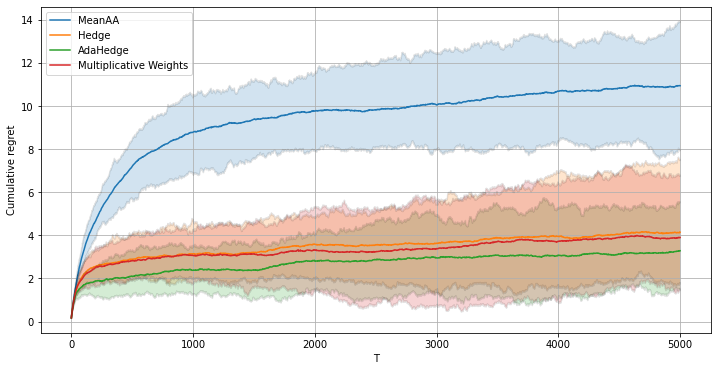

In [27]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for agent in agents:
    agent_df = quantile_df[quantile_df['agent'] == agent]
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    plt.fill_between(x=ts, y1=agent_df[q1_col], y2=agent_df[q2_col], alpha=0.2)
    sns.lineplot(x='T', y=q1_col, data=agent_df, color='black', alpha=0.1)
    sns.lineplot(x='T', y=q2_col, data=agent_df, color='black', alpha=0.1)

plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [28]:
agents = ['Hedge', 'AdaHedge', 'Multiplicative Weights']

In [29]:
agent_to_outperforms = []
for agent in agents:
    tmp = results_df[results_df['algorithm'] == agent].merge(
        results_df[results_df['algorithm'] == 'MeanAA'], on='simulation')
    assert len(tmp) > 0, agent
    # the lower the regret - the better
    n_outperformed = np.sum(tmp['final_regret_x'] < tmp['final_regret_y'])
    agent_to_outperforms.append((agent, n_outperformed))

In [30]:
outperforms_df = pd.DataFrame(agent_to_outperforms, columns=['algorithm', 'outperformed'])
outperforms_df['outperformed proportion'] = outperforms_df['outperformed'] / N_SIMULATIONS
outperforms_df['z-statistic'] = (outperforms_df['outperformed proportion']-0.5)/\
    np.sqrt(outperforms_df['outperformed proportion']*(1-outperforms_df['outperformed proportion'])/N_SIMULATIONS)
outperforms_df['Prob'] = 1-ss.norm.cdf(outperforms_df['z-statistic'])
outperforms_df['Prob'] = outperforms_df['Prob'].round(4)

In [31]:
outperforms_df

,algorithm,outperformed,outperformed proportion,z-statistic,Prob
0,Hedge,49,0.98,24.243661,0.0
1,AdaHedge,49,0.98,24.243661,0.0
2,Multiplicative Weights,49,0.98,24.243661,0.0


#### Agg algorithms with/without mean

In [32]:
agents = [
    'Hedge', 'AdaHedge', 'Multiplicative Weights',
]

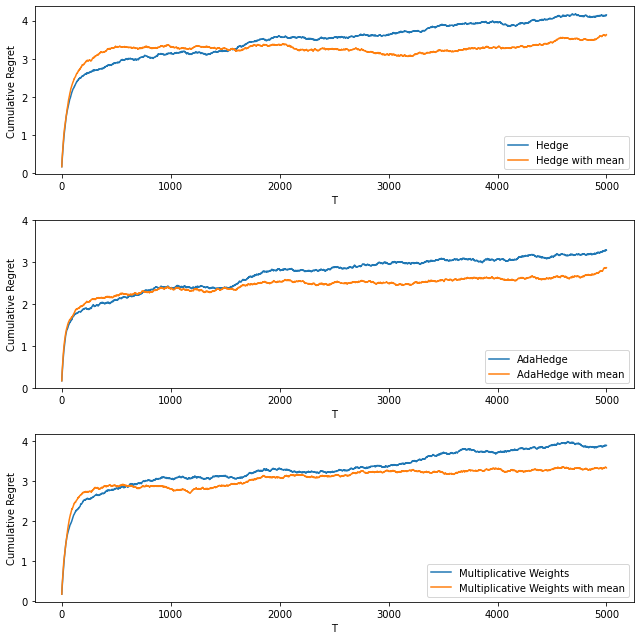

In [33]:
fig,axs=plt.subplots(figsize=(9, 9))
for i, agent in enumerate(agents):
    plt.subplot(3,1,i+1)
    agent_df = quantile_df[quantile_df['agent'] == agent]
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    agent = agent + ' with mean'
    agent_df = quantile_df[quantile_df['agent'] == agent]
    assert len(agent_df) > 0
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    plt.ylabel('Cumulative Regret')
    plt.legend(loc='lower right')
    plt.yticks(np.arange(0, 5, 1))
fig.tight_layout()

In [34]:
agents = ['Hedge', 'AdaHedge', 'Multiplicative Weights']

In [35]:
agent_to_outperforms = []
for agent in agents:
    tmp = results_df[results_df['algorithm'] == agent+' with mean'].merge(
        results_df[results_df['algorithm'] == agent], on='simulation')
    assert len(tmp) > 0, agent
    # the lower the regret - the better
    n_outperformed = np.sum(tmp['final_regret_x'] < tmp['final_regret_y'])
    agent_to_outperforms.append((agent, n_outperformed))

In [36]:
outperforms_df = pd.DataFrame(agent_to_outperforms, columns=['algorithm', 'outperformed'])
outperforms_df['outperformed proportion'] = outperforms_df['outperformed'] / N_SIMULATIONS
outperforms_df['z-statistic'] = (outperforms_df['outperformed proportion']-0.5)/\
    np.sqrt(outperforms_df['outperformed proportion']*(1-outperforms_df['outperformed proportion'])/N_SIMULATIONS)
outperforms_df['Prob'] = 2*(1-ss.norm.cdf(np.abs(outperforms_df['z-statistic'])))
outperforms_df['Prob'] = outperforms_df['Prob'].round(2)

In [37]:
outperforms_df

,algorithm,outperformed,outperformed proportion,z-statistic,Prob
0,Hedge,31,0.62,1.748150,0.08
1,AdaHedge,26,0.52,0.283069,0.78
2,Multiplicative Weights,30,0.60,1.443376,0.15


## Avocado data

In [38]:
import os
from bandits.pricing.bandits import get_avocado_df, PricingAvocadoBanditEnv

In [39]:
base_dir = '../data/avocado/'
os.listdir(base_dir)
avocado_path = os.path.join(base_dir, 'avocado.csv')

In [40]:
avocado_df = get_avocado_df(avocado_path)
K = 10
region = 'DallasFtWorth'
start_date = pd.to_datetime('2018-01-01')
T = 10000

In [41]:
env = PricingAvocadoBanditEnv(
    num_arms=K, avocado_df=avocado_df, region=region, start_date=start_date,
    p_min=0.5, p_max=0.7
)

In [42]:
# just choosing random prices as actions
np.random.seed(1)
sampled_prices = np.random.choice(range(K), size=T)

In [43]:
quantity = []
for i in tqdm(range(T)):
    action = sampled_prices[i]
    observation, reward, done, info = env.step(action)
    quantity.append(reward/env.action_to_price[action])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [44]:
run_df = pd.DataFrame(np.array([sampled_prices, quantity]).T, columns=['price_unmapped', 'quantity'])
run_df['price'] = run_df['price_unmapped'].map({i: j for i,j in enumerate(env.action_to_price)})
run_df['rev'] = run_df['price'] * (run_df['quantity'])

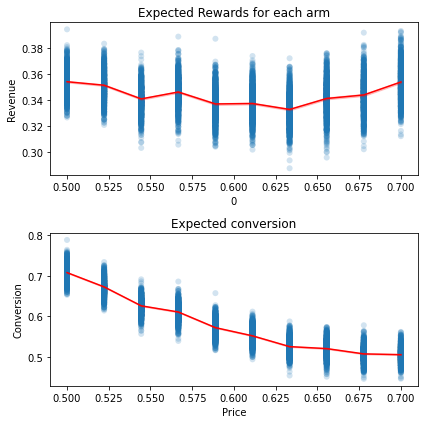

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
sns.scatterplot(x='price', y='rev', data=run_df, edgecolor='none', alpha=0.2)
sns.lineplot(x='price', y='rev', data=run_df, color='red')
plt.ylabel('Revenue')
plt.xlabel(0)
plt.title('Expected Rewards for each arm');

plt.subplot(2, 1, 2)
sns.scatterplot(x='price', y='quantity', data=run_df, edgecolor='none', alpha=0.2)
sns.lineplot(x='price', y='quantity', data=run_df, color='red')
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Expected conversion')

fig.tight_layout();

### Run simulations

> warning: might run for too much time and take too many resources

> set the n_jobs accordingly

In [46]:
avocado_df = get_avocado_df(avocado_path)
K = 10
region = 'DallasFtWorth'
start_date = pd.to_datetime('2018-01-01')
T = 5000
N_SIMULATIONS = 50

eps = 1e-2  # probability of exploration
alpha = 0.2**2/4

In [47]:
def simulate_agent(T, K, dist, p_min, p_max, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    env = PricingAvocadoBanditEnv(
        num_arms=K, avocado_df=avocado_df, region=region, start_date=start_date, T=T, p_min=0.5, p_max=0.7)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    for _ in range(T):
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        reward_history.append(reward)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(env.max_reward - reward_history)
    return rng_seed, name, regret

In [48]:
lr_models = [
    SimpleLinearRegressor(0, 0),
    SimpleLinearRegressor(0, 0, x_transform=np.log),
    SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1),
    SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x),
]
MeanAA_agg_alg = SimpleMeanAggregatingAlgorithm(lr_models)
hedge_agg_alg = Hedge(lr_models)
adahedge_agg_alg = AdaHedge(lr_models)
multw_agg_alg = MultiplicativeWeights(lr_models, eta=0.5)

with_mean_models = lr_models + [TargetEncodingModel()]
h_mean_agg = Hedge(with_mean_models)
ah_mean_agg = AdaHedge(with_mean_models)
mw_mean_agg = MultiplicativeWeights(with_mean_models, eta=0.5)

agent_funcs = [
    ("UCB1", lambda env: UCB1Agent(alpha=0.9*alpha, num_arms=env.action_space.n)),
    ("MeanAA", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=MeanAA_agg_alg, alpha=alpha*1.3, action_to_price=env.action_to_price))),
    ("Hedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=hedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("AdaHedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=adahedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Multiplicative Weights", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=multw_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Hedge with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=h_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
    ("AdaHedge with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=ah_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Multiplicative Weights with mean", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=mw_mean_agg, alpha=alpha, action_to_price=env.action_to_price))),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [49]:
n_jobs = 16
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(T, K, dist, p_min, p_max, agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/400 [00:00<?, ?it/s]

In [50]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])
results_df['final_regret'] = results_df['regret'].apply(lambda x: x[-1])

In [51]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

In [52]:
agents = ['UCB1', 'MeanAA', 'Hedge', 'AdaHedge', 'Multiplicative Weights']

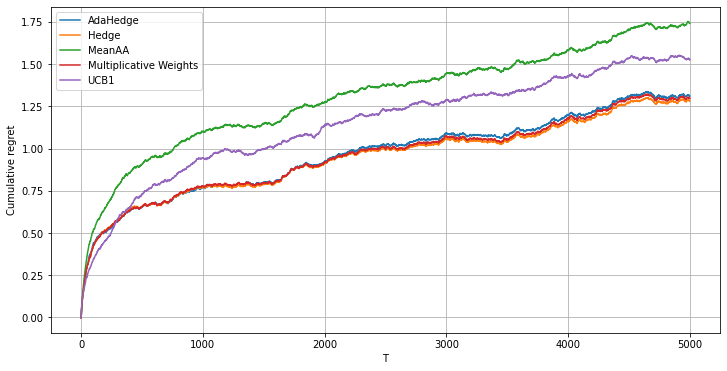

In [53]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    if name not in agents:
        continue
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

### Compare the algorithms

#### quantiles

In [54]:
# quantiles
q1 = 0.1
q2 = 1 - q1

In [55]:
agents = [
    'UCB1', 'MeanAA',
    'Hedge', 'AdaHedge', 'Multiplicative Weights',
    'Hedge with mean', 'AdaHedge with mean', 'Multiplicative Weights with mean']

In [56]:
q1_col = f'quantile {100*q1}%'
q2_col = f'quantile {100*q2}%'

In [57]:
quantile_df = pd.DataFrame()
for name in agents:
    if name not in agent_to_regret.keys():
        continue
    regret = agent_to_regret[name]
    quantiles = np.quantile(regret, [q1, q2], axis=0).T
    mean = np.mean(regret, axis=0)
    qqm = np.hstack([np.quantile(regret, [q1, q2], axis=0).T, np.mean(regret, axis=0).reshape(-1, 1)])
    qqm = pd.DataFrame(qqm, columns=[q1_col, q2_col, 'mean'])
    qqm['agent'] = name
    qqm['T'] = qqm.index
    quantile_df = pd.concat([quantile_df, qqm])

In [58]:
quantile_df[quantile_df['T'] == quantile_df['T'].max()].round(2)

,quantile 10.0%,quantile 90.0%,mean,agent,T
4999,0.99,2.24,1.53,UCB1,4999
4999,0.72,4.03,1.74,MeanAA,4999
4999,0.45,2.84,1.28,Hedge,4999
4999,0.47,2.91,1.31,AdaHedge,4999
4999,0.47,2.84,1.30,Multiplicative Weights,4999
4999,-0.00,0.00,0.02,Hedge with mean,4999
4999,0.02,0.86,0.34,AdaHedge with mean,4999
4999,-0.00,0.00,0.02,Multiplicative Weights with mean,4999


#### UCB, MeanAA, Adaptive

In [59]:
agents = ['UCB1', 'MeanAA', 'AdaHedge']
colors = ['mediumpurple', 'green', 'red']  # to make them match the previous plot

In [60]:
agents = ['UCB1', 'MeanAA', 'AdaHedge']

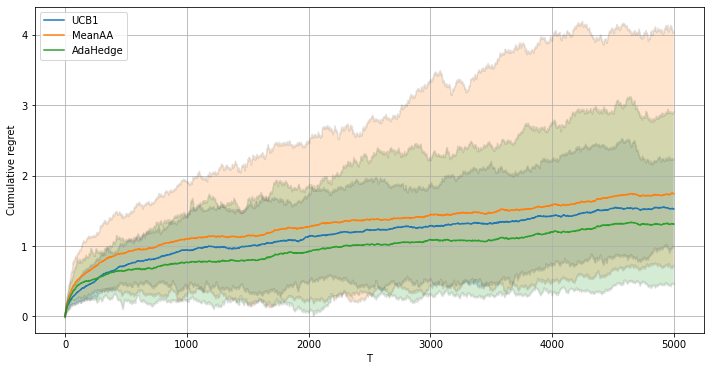

In [61]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for agent in agents:
    agent_df = quantile_df[quantile_df['agent'] == agent]
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    plt.fill_between(x=ts, y1=agent_df[q1_col], y2=agent_df[q2_col], alpha=0.2)
    sns.lineplot(x='T', y=q1_col, data=agent_df, color='black', alpha=0.1)
    sns.lineplot(x='T', y=q2_col, data=agent_df, color='black', alpha=0.1)

plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [62]:
agents = ['MeanAA', 'Hedge', 'AdaHedge', 'Multiplicative Weights']

In [63]:
agent_to_outperforms = []
for agent in agents:
    tmp = results_df[results_df['algorithm'] == agent].merge(
        results_df[results_df['algorithm'] == 'UCB1'], on='simulation')
    assert len(tmp) > 0, agent
    # the lower the regret - the better
    n_outperformed = np.sum(tmp['final_regret_x'] < tmp['final_regret_y'])
    agent_to_outperforms.append((agent, n_outperformed))

In [64]:
outperforms_df = pd.DataFrame(agent_to_outperforms, columns=['algorithm', 'outperformed'])
outperforms_df['outperformed proportion'] = outperforms_df['outperformed'] / N_SIMULATIONS
outperforms_df['z-statistic'] = (outperforms_df['outperformed proportion']-0.5)/\
    np.sqrt(outperforms_df['outperformed proportion']*(1-outperforms_df['outperformed proportion'])/N_SIMULATIONS)
outperforms_df['Prob'] = 2*(1-ss.norm.cdf(np.abs(outperforms_df['z-statistic'])))
outperforms_df['Prob'] = outperforms_df['Prob'].round(4)

In [65]:
outperforms_df.round(4)

,algorithm,outperformed,outperformed proportion,z-statistic,Prob
0,MeanAA,32,0.64,2.0624,0.0392
1,Hedge,34,0.68,2.7285,0.0064
2,AdaHedge,34,0.68,2.7285,0.0064
3,Multiplicative Weights,33,0.66,2.3883,0.0169


#### MeanAA to Adaptive

In [66]:
agents = ['MeanAA', 'Hedge', 'AdaHedge', 'Multiplicative Weights']

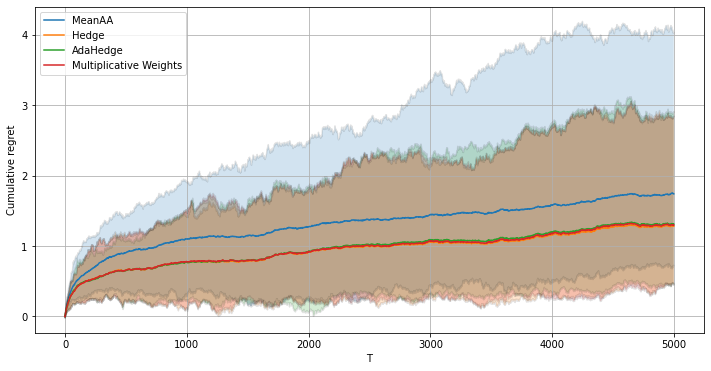

In [67]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for agent in agents:
    agent_df = quantile_df[quantile_df['agent'] == agent]
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    plt.fill_between(x=ts, y1=agent_df[q1_col], y2=agent_df[q2_col], alpha=0.2)
    sns.lineplot(x='T', y=q1_col, data=agent_df, color='black', alpha=0.1)
    sns.lineplot(x='T', y=q2_col, data=agent_df, color='black', alpha=0.1)

plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [68]:
agents = ['Hedge', 'AdaHedge', 'Multiplicative Weights']

In [69]:
agent_to_outperforms = []
for agent in agents:
    tmp = results_df[results_df['algorithm'] == agent].merge(
        results_df[results_df['algorithm'] == 'MeanAA'], on='simulation')
    assert len(tmp) > 0, agent
    # the lower the regret - the better
    n_outperformed = np.sum(tmp['final_regret_x'] < tmp['final_regret_y'])
    agent_to_outperforms.append((agent, n_outperformed))

In [70]:
outperforms_df = pd.DataFrame(agent_to_outperforms, columns=['algorithm', 'outperformed'])
outperforms_df['outperformed proportion'] = outperforms_df['outperformed'] / N_SIMULATIONS
outperforms_df['z-statistic'] = (outperforms_df['outperformed proportion']-0.5)/\
    np.sqrt(outperforms_df['outperformed proportion']*(1-outperforms_df['outperformed proportion'])/N_SIMULATIONS)
outperforms_df['Prob'] = 1-ss.norm.cdf(outperforms_df['z-statistic'])
outperforms_df['Prob'] = outperforms_df['Prob'].round(4)

In [71]:
outperforms_df

,algorithm,outperformed,outperformed proportion,z-statistic,Prob
0,Hedge,41,0.82,5.889681,0.0
1,AdaHedge,41,0.82,5.889681,0.0
2,Multiplicative Weights,41,0.82,5.889681,0.0


#### Agg algorithms with/without mean

In [72]:
agents = [
    'Hedge', 'AdaHedge', 'Multiplicative Weights',
#     'Hedge with mean', 'AdaHedge with mean', 'Multiplicative Weights with mean',
]

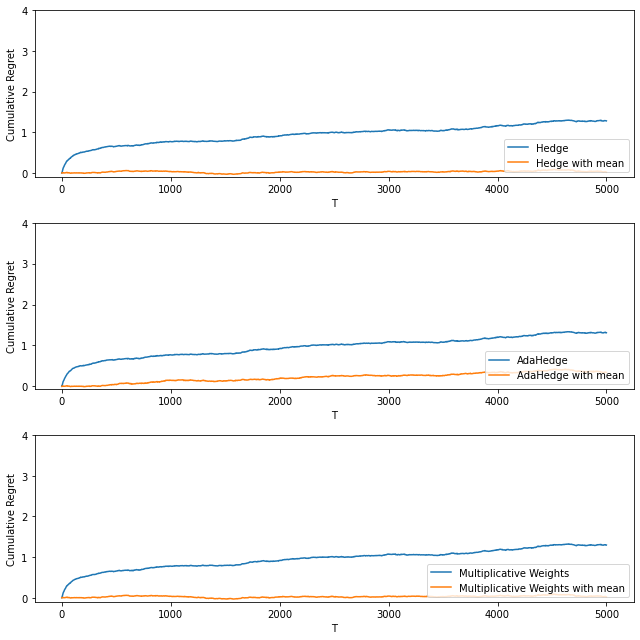

In [73]:
fig,axs=plt.subplots(figsize=(9, 9))
for i, agent in enumerate(agents):
    plt.subplot(3,1,i+1)
    agent_df = quantile_df[quantile_df['agent'] == agent]
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    agent = agent + ' with mean'
    agent_df = quantile_df[quantile_df['agent'] == agent]
    assert len(agent_df) > 0
    sns.lineplot(x='T', y='mean', label=agent, data=agent_df)
    plt.ylabel('Cumulative Regret')
    plt.legend(loc='lower right')
    plt.yticks(np.arange(0, 5, 1))
fig.tight_layout()

In [74]:
agents = ['Hedge', 'AdaHedge', 'Multiplicative Weights']

In [75]:
agent_to_outperforms = []
for agent in agents:
    tmp = results_df[results_df['algorithm'] == agent+' with mean'].merge(
        results_df[results_df['algorithm'] == agent], on='simulation')
    assert len(tmp) > 0, agent
    # the lower the regret - the better
    n_outperformed = np.sum(tmp['final_regret_x'] < tmp['final_regret_y'])
    agent_to_outperforms.append((agent, n_outperformed))

In [76]:
outperforms_df = pd.DataFrame(agent_to_outperforms, columns=['algorithm', 'outperformed'])
outperforms_df['outperformed proportion'] = outperforms_df['outperformed'] / N_SIMULATIONS
outperforms_df['z-statistic'] = (outperforms_df['outperformed proportion']-0.5)/\
    np.sqrt(outperforms_df['outperformed proportion']*(1-outperforms_df['outperformed proportion'])/N_SIMULATIONS)
outperforms_df['Prob'] = 1-ss.norm.cdf(outperforms_df['z-statistic'])
outperforms_df['Prob'] = outperforms_df['Prob'].round(2)

In [77]:
outperforms_df.round(2)

,algorithm,outperformed,outperformed proportion,z-statistic,Prob
0,Hedge,50,1.00,inf,0.0
1,AdaHedge,39,0.78,4.78,0.0
2,Multiplicative Weights,50,1.00,inf,0.0
